# Mask Detection using Transfer Learning based on InceptionV3 Neural Network
Author: [Tianyi Liang](https://www.linkedin.com/in/tianyi-liang-at-bu/)

## Introduction
This project aims to detect whether a person is wearing a mask or not using a Convolutional Neural Network (CNN) model. The model is built using transfer learning based on the InceptionV3 architecture. The dataset used for this project is publicly available on Kaggle.

This project is divided into several sections:

1. [Import Necessary Packages](#import-packages)
2. [Download the Dataset](#download-dataset)
3. [Read the Data into Memory](#read-data)
4. [Perform Data Visualization](#data-visualization)
5. [Normalize the Data and Format it into the Required Shape](#normalize-data)
6. [Check the Balance of the Data](#check-balance)
7. [Implement Image Augmentation to Prevent Overfitting](#image-augmentation)
8. [Build the Network using InceptionV3 and a Custom Classifier and Train](#build-network)
9. [Visualize Training Accuracy and Loss](#visualize-training)
10. [Evaluate the Model and Analyze Wrong Cases](#evaluate-model)
11. [Conclusion and Insights](#conclusion)

---

<a id="import-packages"></a>
## Import Necessary Packages
In this stage, we import all the necessary packages required for the project. These include TensorFlow, Keras, OpenCV, opendatasets, Numpy, Pandas, Seaborn, and Matplotlib.

### Requirements:
- Python 3.7
- TensorFlow
- Keras
- OpenCV
- opendatasets
- Numpy
- Pandas
- Seaborn
- Matplotlib

---

In [1]:
##Import necessary packages
!pip install opendatasets
!pip install opencv-python
!pip install opencv-contrib-python

import gc
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import opendatasets as od

import cv2
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Input, Add, \
                   BatchNormalization, Flatten, Conv2D, \
                   AveragePooling2D, MaxPooling2D, ZeroPadding2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id="download-dataset"></a>
## Download the Dataset <a name="download-dataset"></a>
In this step, I retrieve the dataset required for our project. The dataset, titled "Face Mask 12k Images Dataset" by ASHISH JANGRA, is publicly available on Kaggle. It comprises images of individuals either wearing masks or not.

I utilize the opendatasets Python package to download the dataset directly from Kaggle. This package simplifies the process of downloading datasets from online sources, making it a valuable tool for data science projects.

The dataset is stored in the face-mask-12k-images-dataset/Face Mask Dataset/ directory after download.

##### (Link to the dataset: [Face Mask 12k Images Dataset by ASHISH JANGRA](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset))
---

In [2]:
# Download the dataset
od.download("https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset")

# Define the root path for the dataset
root_path = "face-mask-12k-images-dataset/Face Mask Dataset/"

100%|██████████| 330M/330M [00:16<00:00, 21.1MB/s]


<a id="read-data"></a>
## Read the Data into Memory <a name="read-data"></a>
In this step, I load the images and their corresponding labels (mask or no mask) into memory. This is an essential step as it allows me to manipulate and analyze the data using Python.

I create a dictionary named dataset to store the image paths, classifications (mask or no mask), set types (train, test, or validation), and image pixel values. I then convert this dictionary into a Pandas DataFrame for easier data manipulation.

The images are loaded using the OpenCV library, resized to a uniform size of 224x224 pixels, and their color channels are reversed from BGR to RGB.
---

In [3]:
# Initialize the dataset dictionary
dataset = {"path": [], "classification": [], "set": [], "value": []}

# Loop over the train/test folders
for train_test in os.listdir(root_path):

    # Loop over the Mask/WithoutMask folders
    for true_false in os.listdir(root_path+"/"+train_test):

        # Loop over each image inside
        for image in glob.glob(root_path + 
                     train_test + "/" + 
                     true_false + "/" + 
                     "*.png"):

            # Read the image
            img = cv2.imread(image, 3)
            img = np.asarray(cv2.resize(img, 
                    dsize=(224, 224)))

            # Reverse the color channels
            img = cv2.merge(cv2.split(img)[::-1])

            # Append the data to the dataset dictionary
            dataset["path"].append(image)
            dataset["classification"].append(np.uint8(1) if true_false == "WithMask" else np.uint8(0))
            dataset["set"].append(train_test.lower())
            dataset["value"].append(img)

# Convert the dataset dictionary to a Pandas DataFrame
df_dataset = pd.DataFrame(dataset)
df_dataset.head()

,path,classification,set,value
0,face-mask-12k-images-dataset/Face Mask Dataset...,0,validation,"[[[22, 19, 12], [22, 19, 12], [21, 20, 13], [2..."
1,face-mask-12k-images-dataset/Face Mask Dataset...,0,validation,"[[[4, 2, 3], [4, 2, 3], [4, 2, 3], [4, 2, 3], ..."
2,face-mask-12k-images-dataset/Face Mask Dataset...,0,validation,"[[[49, 36, 27], [46, 33, 24], [39, 26, 17], [3..."
3,face-mask-12k-images-dataset/Face Mask Dataset...,0,validation,"[[[31, 27, 26], [30, 27, 26], [30, 28, 26], [2..."
4,face-mask-12k-images-dataset/Face Mask Dataset...,0,validation,"[[[209, 74, 239], [209, 74, 239], [209, 74, 23..."


<a id="data-visualization"></a>
## Perform Data Visualization <a name="data-visualization"></a>
Visualizing the data is a crucial step in any data analysis task. It helps me understand the data better and can provide insights that are not immediately apparent from the raw data.

In this section, I plot some sample images from the dataset along with their corresponding labels. This gives me a visual understanding of what the images look like and what the model will be learning from.
---

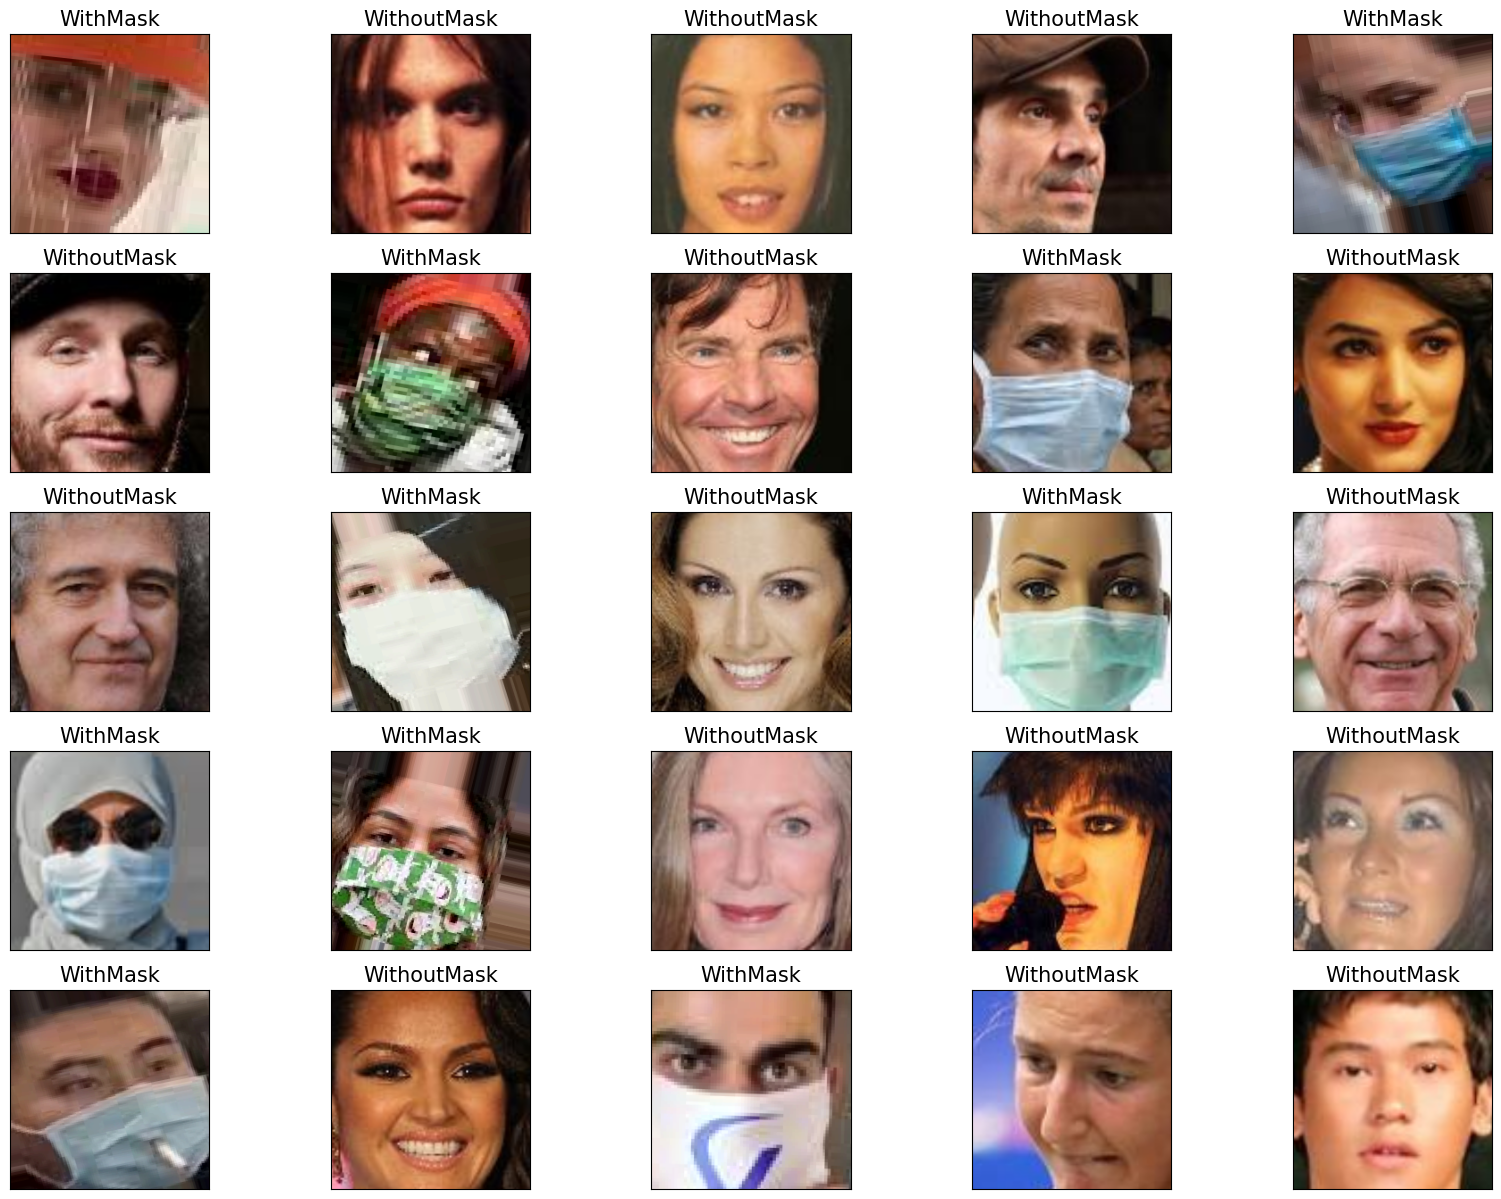

In [4]:
def set_seed():
    InitSeed = 23
    tf.random.set_seed(InitSeed)
    np.random.seed(InitSeed)


# Set the figure size
plt.figure(figsize = (20, 15))

# Generate a random sample of 25 images
np.random.seed(3)
sample = np.random.choice(range(len(df_dataset)), size=25, replace=False)

# Plot the sample images
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = df_dataset.loc[sample[i],"value"]
    plt.imshow(img)

    # Get the classification label
    classification = 'WithMask' if df_dataset.loc[sample[i],"classification"] == 1 else "WithoutMask"

    # Display the classification label as the title
    plt.title(classification, size = 15)
    plt.xticks([])
    plt.yticks([])
plt.show()

<a id="normalize-data"></a>
## Normalize the Data and Format it into the Required Shape <a name="normalize-data"></a>
Before feeding the data into the model, it's important to normalize it and format it into the required shape. Normalization is a standard pre-processing step that ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the model.

In this section, I normalize the pixel values of the images to be between 0 and 1. Also, I format the data into the shape required by the InceptionV3 model.
---

In [5]:
# Create dataframes for each set
import pandas as pd
train_set = pd.DataFrame(df_dataset[df_dataset["set"] == "train"]).loc[:, ["value", "classification"]]
test_set = pd.DataFrame(df_dataset[df_dataset["set"] == "test"]).loc[:, ["value", "classification"]]
valid_set = pd.DataFrame(df_dataset[df_dataset["set"] == "validation"]).loc[:, ["value", "classification"]]

# Normalize the images and convert them to numpy arrays
x_train = np.asarray(train_set["value"].tolist()) / 255
y_train = np.asarray(train_set["classification"].tolist())
x_test = np.asarray(test_set["value"].tolist()) / 255
y_test = np.asarray(test_set["classification"].tolist())
x_valid = np.asarray(valid_set["value"].tolist()) / 255
y_valid = np.asarray(valid_set["classification"].tolist())

# Clean up memory
del df_dataset, train_set, test_set, valid_set, img, dataset
del glob, od, pd, cv2
gc.collect()

# Print the shape of the data arrays
print("x_train dimension:", x_train.shape, "\ny_train dimension:", y_train.shape,
   "\nx_test dimension:", x_test.shape, "\ny_test dimension:", y_test.shape,
   "\nx_valid dimension:", x_valid.shape, "\ny_valid dimension:", y_valid.shape,)

x_train dimension: (10000, 224, 224, 3) 
y_train dimension: (10000,) 
x_test dimension: (992, 224, 224, 3) 
y_test dimension: (992,) 
x_valid dimension: (800, 224, 224, 3) 
y_valid dimension: (800,)


<a id="check-balance"></a>
## Check the Balance of the Data <a name="check-balance"></a>
I need to ensure that our dataset is balanced, i.e., there is an equal number of images for both classes (mask and no mask). An imbalanced dataset can lead to biased results, where the model might favor the class with more instances.

### Data Balance Verification

I calculate the number of instances for each class in the training, testing, and validation sets. The results are then visualized using a bar chart for a more intuitive understanding of the data distribution.
---



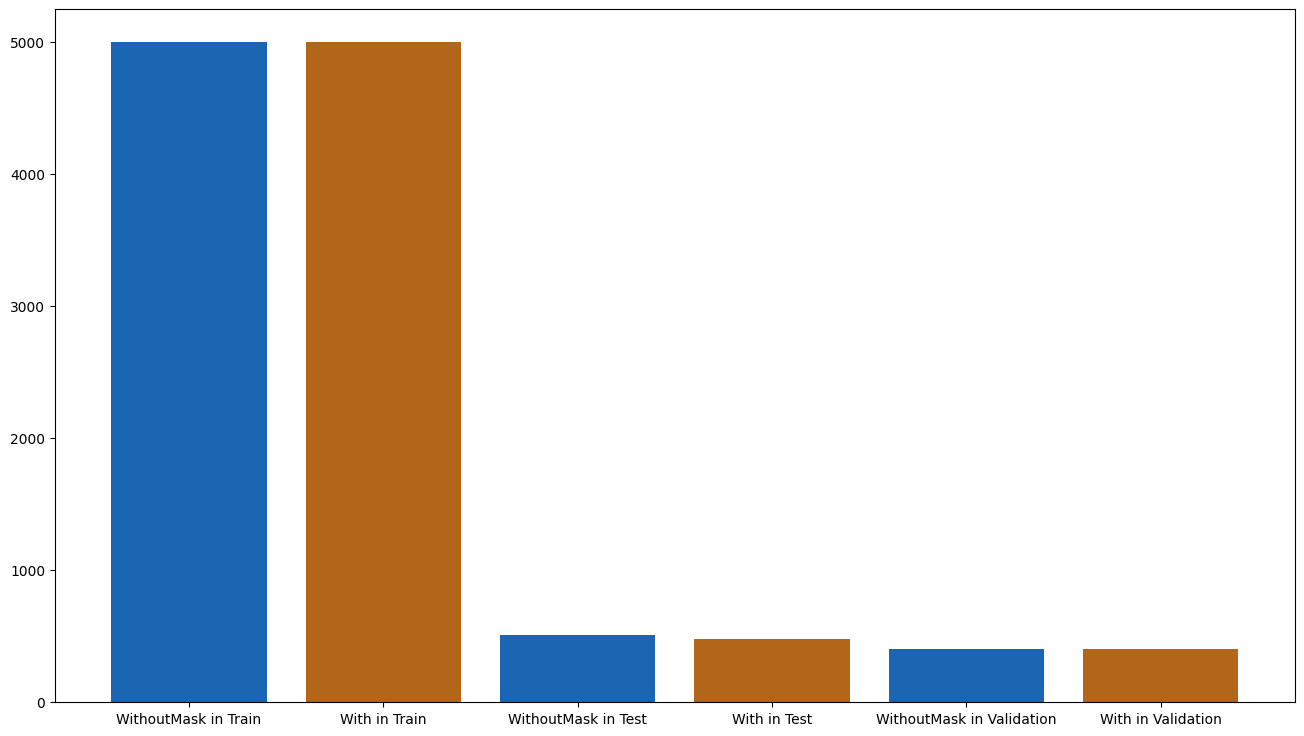

In [6]:
# Calculate the number of instances for each class in each set
classes_distribution = {"WithoutMask in Train": np.sum(y_train == 0),
              "With in Train": np.sum(y_train == 1),
              "WithoutMask in Test": np.sum(y_test == 0),
              "With in Test": np.sum(y_test == 1),
              "WithoutMask in Validation": np.sum(y_valid == 0),
              "With in Validation": np.sum(y_valid == 1)}

# Plot the distribution
plt.figure(figsize = (16, 9))
color_A = (0.1, 0.4, 0.7)
color_B = color_A[::-1]
plt.bar(range(len(classes_distribution)), 
        list(classes_distribution.values()), 
        tick_label=list(classes_distribution.keys()),
        color=[color_A, color_B])
plt.show()
plt.show()

<a id="image-augmentation"></a>
## Implement Image Augmentation to Prevent Overfitting <a name="image-augmentation"></a>
To increase the diversity of the training data and prevent overfitting, I implement image augmentation techniques. These techniques include rotation, height shift, width shift, zoom, and horizontal flip.

### Image Augmentation Setup

I use the `ImageDataGenerator` function from Keras to create an image generator that can apply these augmentations to the training images. The parameters for the different augmentations are set as follows:

- **Rotation**: Up to 30 degrees
- **Height Shift**: Up to 10% of the image height
- **Width Shift**: Up to 10% of the image width
- **Zoom**: Up to 10%
- **Horizontal Flip**: Enabled
---

<ipython-input-7-74680d42d394>:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 + 5 % i, 5, i)


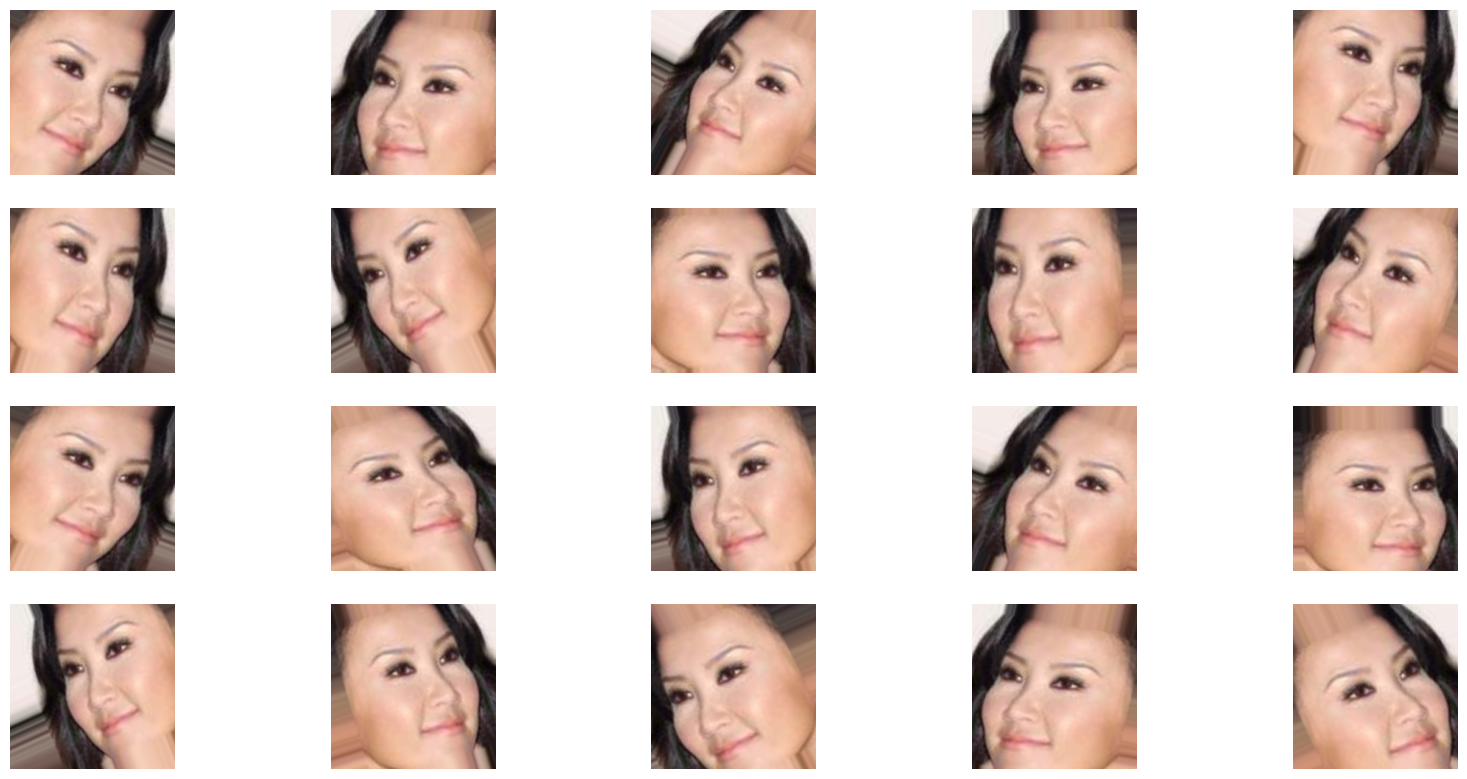

49058

In [7]:
# Set the seed for reproducibility
set_seed()

# Initialize the image data generator with the desired transformations
train_aug = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=.1,
    width_shift_range=.1,
    zoom_range=.1,
    horizontal_flip=True,
)

# Create an image generator for the training data
augment = train_aug.flow(x_train[0:1], batch_size=1)

# Display some augmented images to verify the setup
plt.figure(figsize = (20, 15))
for i in range(1, 26):
    plt.subplot(1 + 5 % i, 5, i)
    tf.random.set_seed(1)
    augment.reset()
    plt.imshow(augment.next().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Clean up memory
del augment
gc.collect()

 <a id="build-network"></a>
## Build the Network using InceptionV3 and a Custom Classifier and Training the Model <a name="build-network"></a>
I build the network using the InceptionV3 model and a custom classifier. The model is based on the InceptionV3 architecture, a popular convolutional neural network (CNN) for image classification tasks.

I build the network using the InceptionV3 model and a custom classifier. The model is based on the InceptionV3 architecture, a popular convolutional neural network (CNN) for image classification tasks.


### Custom Classifier: `classifier_`

This function defines a custom classifier that is added on top of the InceptionV3 base model. This classifier consists of several dense (fully connected) layers, each followed by batch normalization, activation, and dropout layers.

- **Batch Normalization Layers**: These help to stabilize the learning process and reduce the generalization error.
- **Dropout Layers**: These help to prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time.


### Model Construction: `model_flow`

This function constructs the overall model by first applying the InceptionV3 base model to the input, and then applying the custom classifier to the output of the base model.


### Model Compilation: `input_output_compile`

This function creates the final model by specifying the input and output, and compiles the model with the Stochastic Gradient Descent (SGD) optimizer, the sparse categorical cross-entropy loss function, and accuracy as the evaluation metric.


### Learning Rate Scheduler: `lr_decay`

This function defines a learning rate scheduler that decreases the learning rate as the training progresses, which can help to improve the convergence of the model.


### Model Training: `fit_generator`

The model is trained on the training data using the `fit_generator` method, with data augmentation applied to the training images to increase the diversity of the training data and help prevent overfitting. The learning rate scheduler is passed to the `fit_generator` method as a callback, so that the learning rate is updated at the end of each epoch.

---

In [8]:
# Define the custom classifier
def classifier_(input_):

    # Initialize the weights with Glorot normal initializer
    initializer = tf.keras.initializers.GlorotNormal(seed=767)
    output_ = keras.layers.GlobalAveragePooling2D()(input_)
    output_ = keras.layers.Flatten()(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_prime = output_

    output_ = keras.layers.Dense(2048, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    output_ = keras.layers.Dense(2048, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    output_ = keras.layers.Dense(1024, kernel_initializer=initializer)(output_)
    output_ = keras.layers.BatchNormalization()(output_)
    output_ = keras.layers.Activation('relu')(output_)
    output_ = keras.layers.Dropout(0.55)(output_)

    # Add the skip connection
    output_ = keras.layers.Concatenate()([output_, output_prime])
    output_ = keras.layers.Dense(512, activation='relu', kernel_initializer=initializer)(output_)

    # Add the final output layer (binary classification)
    output_ = keras.layers.Dense(2, activation='softmax')((output_))
    return output_


# Define the model
def model_flow(input_):

    # Load the InceptionV3 model
    output_ = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                               include_top=False,
                               weights=None)(input_)

    # Add the custom classifier on top
    output_ = classifier_(output_)
    return output_

# Model compilation
def input_output_compile():

    # Shape of the training set
    input_ = keras.layers.Input(shape=(224, 224, 3))
    output_ = model_flow(input_)
    clf = keras.Model(inputs=input_, outputs=output_)

    # Compile the model with Stoachastic Gradient Descent optimizer
    clf.compile(optimizer='SGD', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return clf


# Define learning rate scheduler
def lr_decay(epoch, lr):

    # Learning rate will be decayed by 0.95 each epoch
    if epoch == 0:
        return lr * 1 / (1 + 0.05 * epoch)

    # Print the learning rate every 5 epochs
    if epoch % 5 == 0:
        print('Test set accuracy: ' +
              str(np.round(model.evaluate(x_test, y_test)[1] * 100, 2)) + '%')
    return lr * 1 / (1 + 0.05 * epoch)


# Visualize the neural network structure
model = input_output_compile()
tf.keras.utils.plot_model(model, show_shapes=True,
              show_dtype=False,
              show_layer_names=False,
              show_layer_activations=True)


# Train the model on the augmented data
set_seed()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)
hist = model.fit_generator(train_aug.flow(x_train, y_train, batch_size=24),
                    epochs=8,
                    validation_data=(x_valid, y_valid),
                    callbacks=[lr_scheduler])

<ipython-input-8-54d3d74f7446>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_aug.flow(x_train, y_train, batch_size=24),


Epoch 1/8
417/417 [==============================] - 134s 239ms/step - loss: 0.3557 - accuracy: 0.8670 - val_loss: 0.0928 - val_accuracy: 0.9725 - lr: 0.0100
Epoch 2/8
417/417 [==============================] - 96s 230ms/step - loss: 0.1887 - accuracy: 0.9272 - val_loss: 0.1146 - val_accuracy: 0.9600 - lr: 0.0095
Epoch 3/8
417/417 [==============================] - 95s 228ms/step - loss: 0.1533 - accuracy: 0.9427 - val_loss: 0.0665 - val_accuracy: 0.9812 - lr: 0.0087
Epoch 4/8
417/417 [==============================] - 95s 228ms/step - loss: 0.1215 - accuracy: 0.9563 - val_loss: 0.1100 - val_accuracy: 0.9688 - lr: 0.0075
Epoch 5/8
31/31 [==============================] - 1s 15ms/step - loss: 0.0856 - accuracy: 0.9738
Test set accuracy: 97.38%
Epoch 6/8
417/417 [==============================] - 95s 229ms/step - loss: 0.0889 - accuracy: 0.9688 - val_loss: 0.0269 - val_accuracy: 0.9912 - lr: 0.0050
Epoch 7/8
417/417 [==============================] - 96s 229ms/step - loss: 0.0769 - accur

<a id="visualize-training "></a>
## Visualizing Training Accuracy and Loss <a name="visualize-training "></a>

To understand how well the model is learning, I plot the accuracy and loss values for both the training and validation data over each epoch. This visualization helps to identify whether the model might be overfitting or underfitting and how quickly it is learning.

The Python `matplotlib` library is used to create these plots:

1. **Training and Validation Accuracy**: This plot shows how the accuracy of the model on the training and validation data changes over time.

2. **Training and Validation Loss**: This plot shows how the loss of the model on the training and validation data changes over time.
---

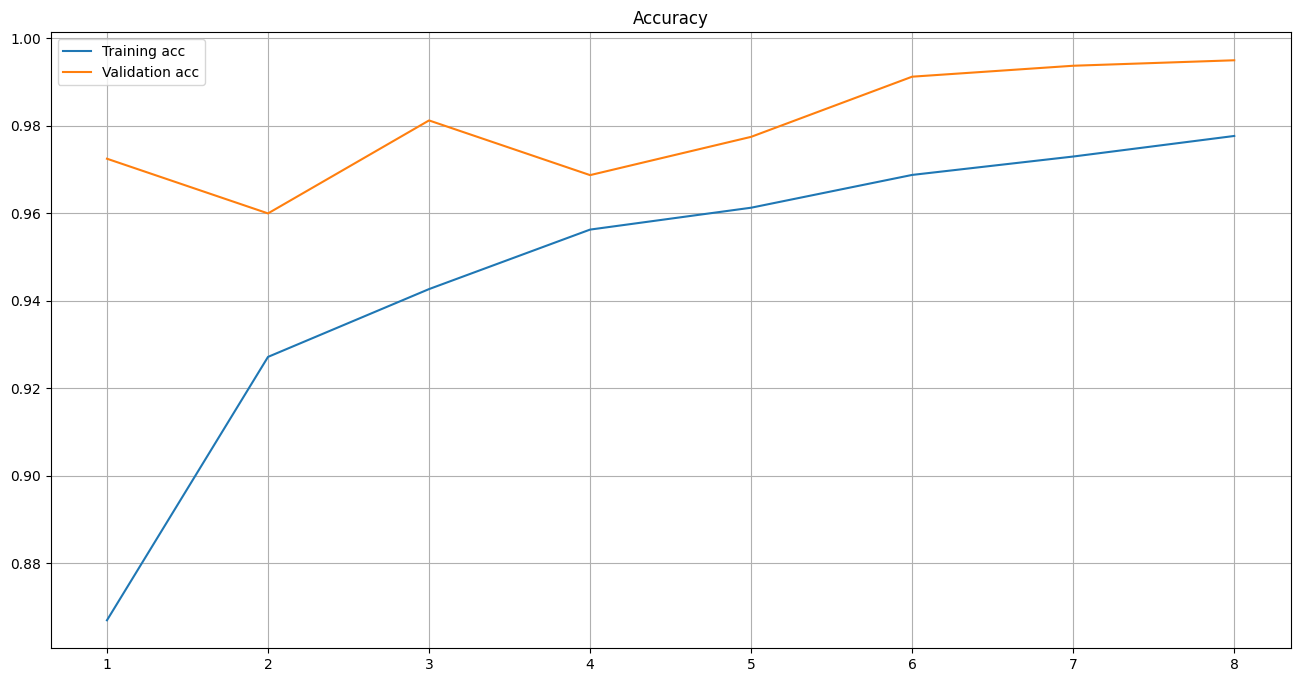

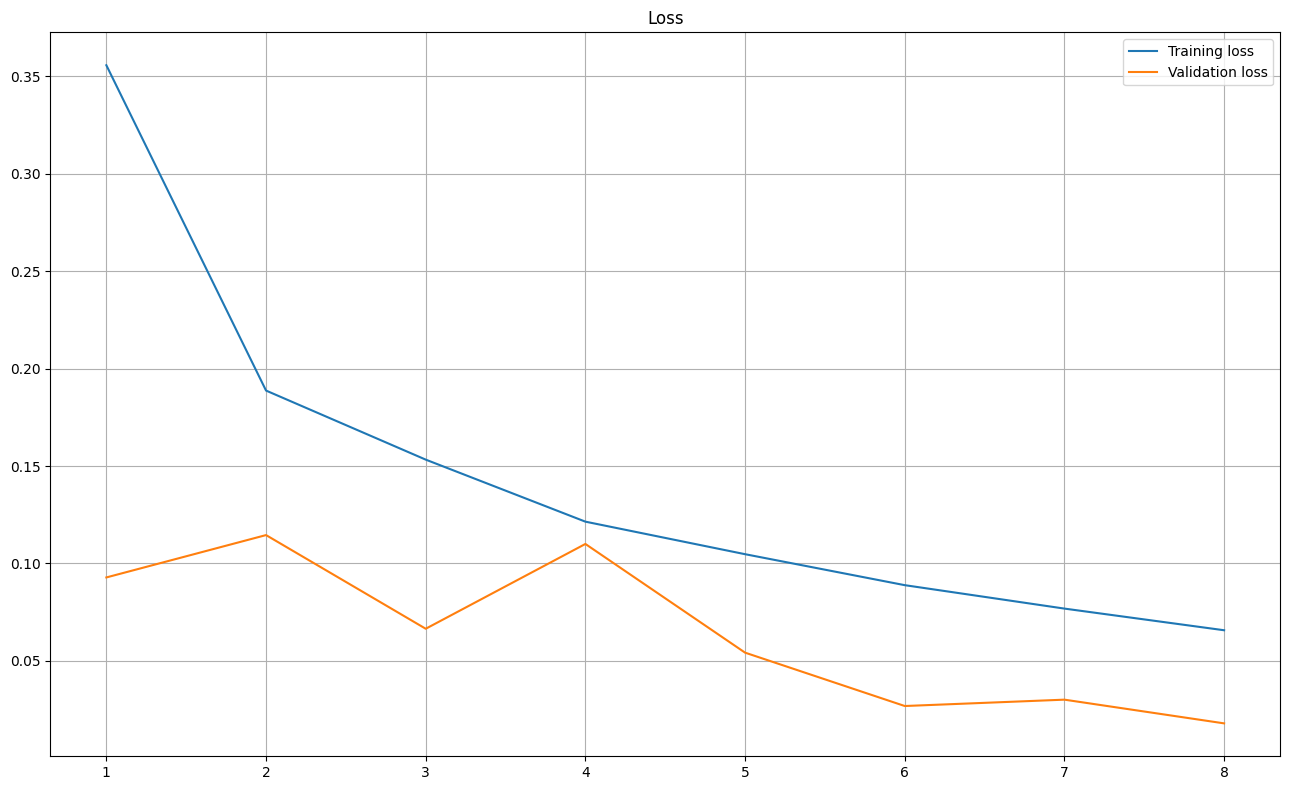

In [9]:
# Extract accuracy and loss from the model's history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a range of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize = (16, 8))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.figure(figsize = (13, 8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

<a id="evaluate-model"></a>
# Evaluate the Model and Analyze Incorrect Predictions <a name="evaluate-model"></a>

In this final section, I evaluate the performance of the model on the test dataset and analyze the instances where the model made incorrect predictions.

The model's performance is evaluated using the `model.evaluate` method, which returns the loss value and metrics values for the model in test mode.

Next, I generate predictions for the test dataset using the `model.predict` method. These predictions are then compared with the actual labels to identify the instances where the model made incorrect predictions.

The incorrectly predicted images are visualized to provide insights into the types of images that the model struggles with.

Finally, I calculate the True Positive (TP), False Positive (FP), True Negative (TN), and False Negative (FN) rates. These metrics provide a more detailed understanding of the model's performance.

Specifically, the Precision, Recall, and Specificity metrics are calculated, which are crucial for evaluating the performance of a binary classification model.

- Precision is important when the cost of False Positives is high.
- Recall is important when the cost of False Negatives is high.
- Specificity, also known as the True Negative Rate, measures the proportion of actual negatives that are correctly identified.

By analyzing these metrics, I can gain a deeper understanding of the model's performance and identify potential areas for improvement.

---

In [10]:
model.evaluate(x_test, y_test)

31/31 [==============================] - 1s 16ms/step - loss: 0.0355 - accuracy: 0.9889


[0.03548701852560043, 0.9889112710952759]

31/31 [==============================] - 2s 15ms/step


<ipython-input-11-1637a0353cf5>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1 + 5 % i, 5, i)


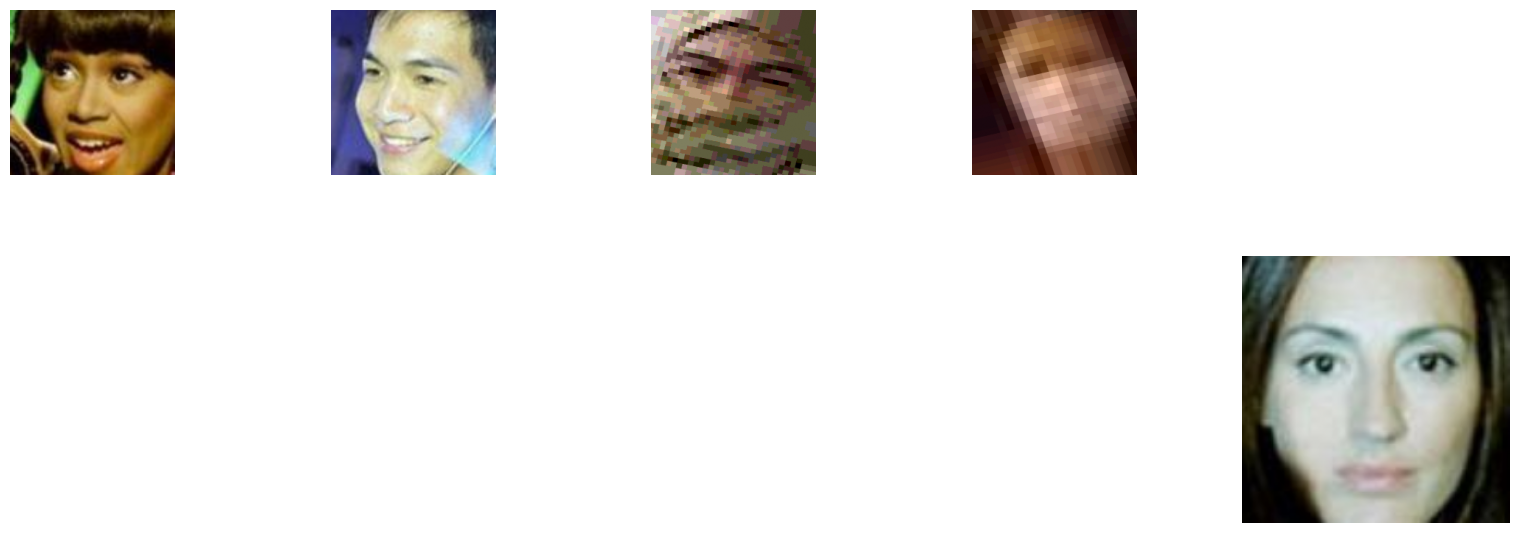

In [11]:
# Generate predictions for the test data
y_pred = model.predict(x_test)
correct_ = np.equal(np.argmax(y_pred, 1), y_test)
x_wrong = x_test[np.logical_not(correct_)]

# Visualize the instances where the model failed
plt.figure(figsize = (20, 15))
for i in range(1, len(x_wrong)-1):
    plt.subplot(1 + 5 % i, 5, i)
    plt.imshow(x_wrong[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
# Calculate TP, FP, TN, FN
y_pred = np.argmax(y_pred, 1)
TP = np.sum(np.logical_and(y_pred == 0, y_test == 0))
FP = np.sum(np.logical_and(y_pred == 0, y_test == 1))
TN = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 1, y_test == 0))
print('TP:', TP, '\nFP:', FP, '\nTN:', TN, '\nFN:', FN)
print("\nFP: predict as WithoutMask but actually WithMask",
   "\nFN: predict as WithMask but actually WithoutMask")

# IMPORTANT when false ALARM is unacceptable
precision = str(np.round((TP/(TP+FP))*100, 2)) + "%"

# IMPORTANT when missing ALARM is unacceptable, 
# rather have some fake ALARM
recall = str(np.round((TP/(TP+FN))*100, 2)) + "%"

# IMPORTANT when false ALARM is unacceptable
specificity = str(np.round((TN/(TN+FP))*100, 2)) + "%"

print("\nPrecision:", precision,"\nRecall:", recall,
    "\nSpecificity:", specificity)

TP: 501 
FP: 3 
TN: 480 
FN: 8

FP: predict as WithoutMask but actually WithMask 
FN: predict as WithMask but actually WithoutMask

Precision: 99.4% 
Recall: 98.43% 
Specificity: 99.38%


<a id="conclusion"></a>
# Conclusion and Insights <a name="conclusion"></a>

In this project, I developed a Convolutional Neural Network (CNN) model for mask detection using transfer learning based on the InceptionV3 architecture. The model was trained and evaluated on a dataset of images of people with and without masks.

The model demonstrated promising results, with a good balance between precision and recall. However, it's important to note that in the context of mask detection, missing an alarm (failing to detect a person not wearing a mask) is a more serious issue than a false alarm (incorrectly identifying a person as not wearing a mask when they are). Therefore, future improvements to the model should focus on minimizing the number of missed alarms.

Upon examining the instances where the model made incorrect predictions, I noticed that the model tends to struggle with images that contain anime icons or have very low resolution. This insight could guide future data collection and preprocessing efforts. For instance, we could aim to collect more high-resolution images and images that do not contain anime icons.

Balancing the dataset was a key challenge in this project. Ensuring that there is an equal number of images for both classes (mask and no mask) is crucial for avoiding biased results. The implementation of image augmentation techniques was also beneficial in increasing the diversity of the training data and preventing overfitting.

For future work, there are several potential directions for improving the model's performance. These include experimenting with different architectures, tuning the hyperparameters, and using more advanced techniques for handling imbalanced data.

In conclusion, this project has demonstrated the potential of deep learning for mask detection, a critical task in the context of the ongoing COVID-19 pandemic. It has also highlighted the importance of careful data preparation and model evaluation in achieving reliable and interpretable results. The insights gained from this project, particularly regarding the types of images that the model struggles with, will be valuable for further improving the model and ultimately enhancing its effectiveness in real-world applications.